In [1]:
# import sys
# sys.path.insert(0,'/p/project/training2005/jupyter/kernels/tensorflow_test/lib/python3.6/site-packages')
# import tensorflow

import tensorflow.keras as keras
from keras import layers, Input, Model
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
ttd = np.reshape(np.load('/p/project/training2005/HZG_Challenge/tas_train.npy'),(900,54,43))
ptd = np.reshape(np.load('/p/project/training2005/HZG_Challenge/tas_train.npy'),(900,54,43))
ntd = np.load('/p/project/training2005/HZG_Challenge/nao_index_train.npy')

ttst = np.reshape(np.load('/p/project/training2005/HZG_Challenge/tas_train.npy'),(900,54,43))
ptst = np.reshape(np.load('/p/project/training2005/HZG_Challenge/tas_train.npy'),(900,54,43))

#plt.plot(range(data.shape[1]),data[0])

def _add_layer(dim, input_tensor, activ):
    if activ != '':
        x = layers.Dense(dim, activation=activ)(input_tensor)
    else: 
        x = layers.Dense(dim)(input_tensor)
    x = layers.BatchNormalization()(x)
    return x

def dense_cell(dim, input_tensor, activs):
    x = _add_layer(dim, input_tensor, activs[0])
    for a in activs[1:]:
        x = _add_layer(dim,x,a)
        
    return x


def cnn_cell(x, ks, st, filters):
    x_shortcut = x
    x = layers.Conv2D(filters=filters[0], kernel_size=1, strides=st, activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(filters=filters[1], kernel_size=ks, strides=1, activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(filters=filters[2], kernel_size=1, strides=1, padding='same')(x)
#     x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same')(x)
#     x = layers.UpSampling1D(size=5)(x)
    x = layers.Add()([x,x_shortcut])
#     x = layers.BatchNormalization()(x)
    return x

def build_model():
    inp1 = Input(shape=(54,43,1))
    inp2 = Input(shape=(54,43,1))
    #out = layers.Dense(1)(inp)
    
    #first branch
    cx = cnn_cell(inp1, 2, 1, [2,2,2])
    x = dense_cell(10, cx, ['relu']*2 + [''])
    
    #second branch
    cy = cnn_cell(inp2, 2, 1, [2,2,2])
    y = dense_cell(10, cy, ['relu']*2 + [''])
    
    #merge branches
    out = layers.Add()([x,y])
    out = layers.Flatten()(out)
    out = layers.Dense(1)(out)
    model = Model([inp1,inp2], out)
  
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model

def train_model(model, params ={'vsplit':0.111,'ne':145,'bs':128}):
#     d1 = 
    history = model.fit([np.reshape(ttd,(ttd.shape[0],ttd.shape[1],1)),
                         np.reshape(ptd,(ptd.shape[0],ptd.shape[1],1))], 
                        np.reshape(ntd,(ntd.shape[0],1)),
                        epochs=params['ne'], 
                        batch_size=params['bs'],
                        validation_split=params['vsplit'])
    return [model, history]

def test_model(model):
    return model.predict([ttst,ptst])

def plot_losses(epochs, history):
    #ks = history.keys()
    ks =['loss','val_loss','mean_absolute_error','val_mean_absolute_error']
    [plt.plot(range(epochs), history[k],'x-') for k in ks]
    plt.show()

/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated;

In [2]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [30]:
model,loss = train_model(model)

Train on 800 samples, validate on 100 samples
Epoch 1/145
800/800 [==============================] - 32s 41ms/step - loss: 6.5359 - mean_absolute_error: 2.0194 - val_loss: 38154.1641 - val_mean_absolute_error: 174.0265
Epoch 2/145
800/800 [==============================] - 0s 263us/step - loss: 11.3648 - mean_absolute_error: 2.4789 - val_loss: 27931.8047 - val_mean_absolute_error: 139.4791
Epoch 3/145
800/800 [==============================] - 0s 254us/step - loss: 19.1361 - mean_absolute_error: 3.4130 - val_loss: 3392.5613 - val_mean_absolute_error: 44.1350
Epoch 4/145
800/800 [==============================] - 0s 252us/step - loss: 6.9136 - mean_absolute_error: 2.1239 - val_loss: 2320.3662 - val_mean_absolute_error: 38.0422
Epoch 5/145
800/800 [==============================] - 0s 252us/step - loss: 6.7775 - mean_absolute_error: 2.0814 - val_loss: 10400.9561 - val_mean_absolute_error: 80.2364
Epoch 6/145
800/800 [==============================] - 0s 252us/step - loss: 4.4201 - mean_a

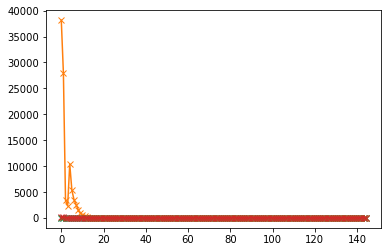

In [31]:
plot_losses(145,loss.history)